### Import Libraries

In [2]:
# Import Libraries
# Importing Numpy & Pandas for data processing & data wrangling
import numpy as np
import pandas as pd

# Importing  tools for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Import functions to work with sparse matrices
from scipy.sparse import vstack, hstack, csr_matrix

# Library used for textual data preprocessing
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold

# Import LabelBinarizer to convert labels into numerical representations
from sklearn.preprocessing import LabelBinarizer

# Import the ML models for regression tasks
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

# Import time format
import time

# Library used for ignore warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aswaj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Dataset Loading

In [3]:
train = pd.read_csv("dataset/train.tsv", sep="\t")

In [4]:
test = pd.read_csv("dataset/test.tsv", sep="\t")

In [5]:
combined = pd.concat([train,test])
submission = test[['test_id']]
train_size = len(train)
y = np.log1p(train['price'])
combined_ML = combined.sample(frac=0.1).reset_index(drop=True)

### Dataset First View

In [6]:
combined_ML.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,test_id
0,356813.0,Doc Martens Ankle Double Zip Black,3,Women/Shoes/Boots,Dr. Martens,51.0,0,"UK 7, USA Womans-9 but fit a woman's 9.5 True ...",NaN
1,1133464.0,Black boutique infinity scarf,1,Women/Women's Accessories/Scarves & Wraps,NaN,7.0,0,NWT- Never worn black infinity scarf. Purchase...,NaN
2,579165.0,2-PACKS OF MAC MASCARA,1,Beauty/Makeup/Eyes,MAC,16.0,0,Black,NaN
3,NaN,Victoria's Secret PINK ultimate leggings,3,"Women/Athletic Apparel/Pants, Tights, Leggings",PINK,NaN,0,Victoria's Secret PINK ultimate leggings bundl...,156324.0
4,1347197.0,Tory burch small bag,3,Women/Women's Handbags/Shoulder Bag,Tory Burch,56.0,0,Authentic Is used need to be cleaner inside ot...,NaN


In [61]:
combined_ML["item_description"][0]

' uk usa womans fit womans true fit great condition soles leather look perfect ripsstains tr♡de womans size chacos'

In [62]:
combined_ML["name"][0]

' doc martens ankle double zip black'

In [63]:
combined_ML["item_condition_id"][0]

np.int64(3)

In [64]:
combined_ML["category_name"][0]

'Women/Shoes/Boots'

In [65]:
combined_ML["brand_name"][0]

'Dr. Martens'

### Dataset Rows & Columns count

In [7]:
print("Number of rows are: ",combined_ML.shape[0])
print("Number of columns are: ",combined_ML.shape[1])

Number of rows are:  217589
Number of columns are:  9


In [8]:
combined_ML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217589 entries, 0 to 217588
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   train_id           148406 non-null  float64
 1   name               217589 non-null  object 
 2   item_condition_id  217589 non-null  int64  
 3   category_name      216636 non-null  object 
 4   brand_name         125085 non-null  object 
 5   price              148406 non-null  float64
 6   shipping           217589 non-null  int64  
 7   item_description   217589 non-null  object 
 8   test_id            69183 non-null   float64
dtypes: float64(3), int64(2), object(4)
memory usage: 14.9+ MB


#### Duplicate Values

In [9]:

dup = combined_ML.duplicated().sum()
print(f'number of duplicated rows are {dup}')

number of duplicated rows are 0


#### Missing Values/Null Values

In [10]:
combined_ML.isnull().sum()

train_id              69183
name                      0
item_condition_id         0
category_name           953
brand_name            92504
price                 69183
shipping                  0
item_description          0
test_id              148406
dtype: int64

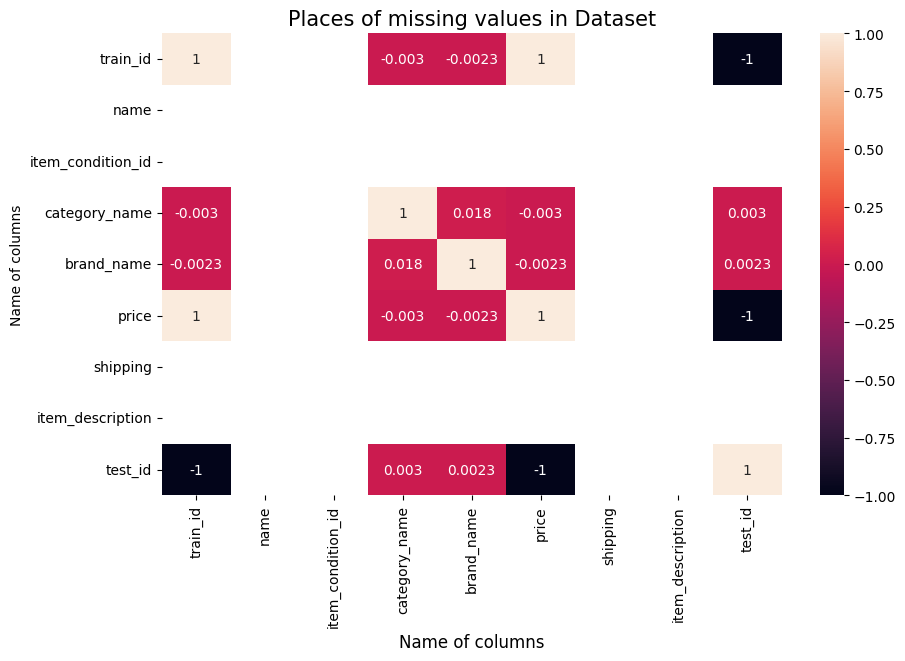

In [11]:

plt.figure(figsize = (10,6))


sns.heatmap(combined_ML.isnull().corr(), vmin=-1, annot= True)


plt.xlabel('Name of columns', fontsize=12)
plt.ylabel('Name of columns', fontsize=10)
plt.title('Places of missing values in Dataset', fontsize=15)


plt.show()


In [12]:
combined_ML.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'test_id'],
      dtype='object')

In [13]:
combined_ML.describe()

,train_id,item_condition_id,price,shipping,test_id
count,1.484060e+05,217589.000000,148406.000000,217589.000000,69183.000000
mean,7.411228e+05,1.906879,26.850316,0.448097,347084.995013
std,4.271038e+05,0.903778,38.343039,0.497300,200234.879625
min,1.000000e+00,1.000000,0.000000,0.000000,21.000000
25%,3.714230e+05,1.000000,10.000000,0.000000,173786.500000
50%,7.400110e+05,2.000000,17.000000,0.000000,346640.000000
75%,1.110436e+06,3.000000,30.000000,1.000000,520137.500000
max,1.482527e+06,5.000000,1850.000000,1.000000,693356.000000


In [14]:
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

### Variables Description

### Check Unique Values for each variable.

In [15]:
for i in combined_ML.columns.tolist():
  print("No. of unique values in",i,"is",combined_ML[i].nunique())

No. of unique values in train_id is 148406
No. of unique values in name is 199313
No. of unique values in item_condition_id is 5
No. of unique values in category_name is 1074
No. of unique values in brand_name is 2670
No. of unique values in price is 450
No. of unique values in shipping is 2
No. of unique values in item_description is 195406
No. of unique values in test_id is 69183


### Data Wrangling

In [16]:
def handle_missing_values(df):
    df['category_name'].fillna(value='missing', inplace=True)
    df['brand_name'].fillna(value='None', inplace=True)
    df['item_description'].fillna(value='None', inplace=True)

In [17]:
handle_missing_values(combined)
handle_missing_values(combined_ML)

In [18]:
def to_categorical(df):
    df['brand_name'] = df['brand_name'].astype('category')
    df['category_name'] = df['category_name'].astype('category')
    df['item_condition_id'] = df['item_condition_id'].astype('category')

In [19]:
to_categorical(combined)
to_categorical(combined_ML)

In [20]:
combined.item_description = combined.item_description.astype(str)
combined_ML.item_description = combined_ML.item_description.astype(str)

## ***4. Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables***

#### Chart - 1 : Price Distribution

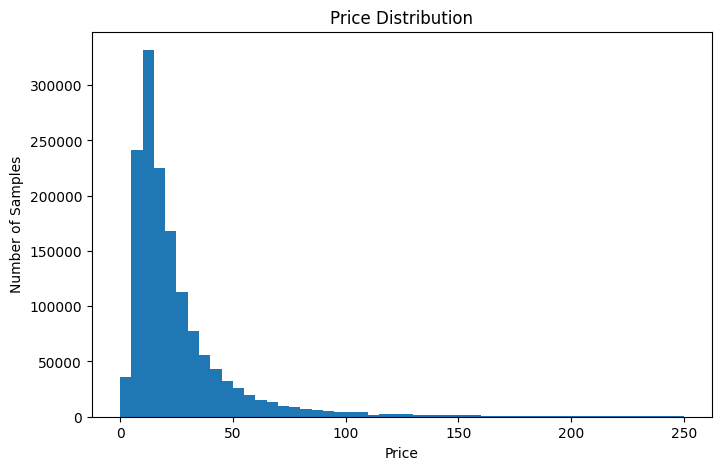

In [21]:

plt.figure(figsize=(8, 5))

plt.hist(train['price'], bins=50, range=[0, 250], label='price')


plt.title('Price Distribution', fontsize=12)
plt.xlabel('Price', fontsize=10)
plt.ylabel('Number of Samples', fontsize=10)


plt.show()

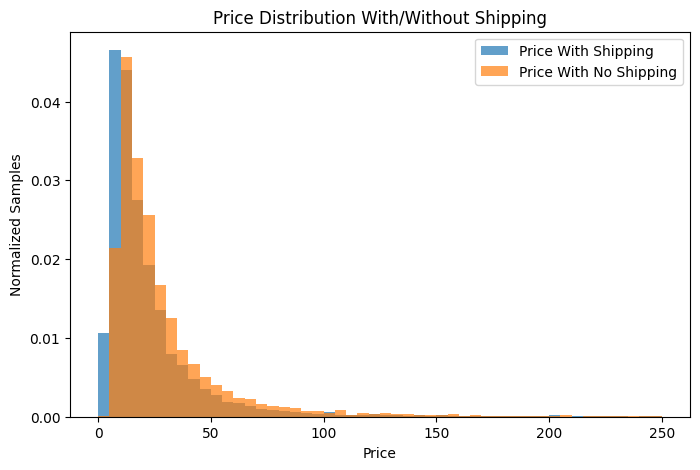

In [22]:

shipping = train[train['shipping'] == 1]['price']
no_shipping = train[train['shipping'] == 0]['price']


plt.figure(figsize=(8, 5))


plt.hist(shipping, bins=50, density=True, range=[0, 250], alpha=0.7, label='Price With Shipping')
plt.hist(no_shipping, bins=50, density=True, range=[0, 250], alpha=0.7, label='Price With No Shipping')


plt.title('Price Distribution With/Without Shipping', fontsize=12)
plt.xlabel('Price', fontsize=10)
plt.ylabel('Normalized Samples', fontsize=10)


plt.legend(fontsize=10)


plt.show()

#### Chart - 2 : Distribution of Top 10 Brand

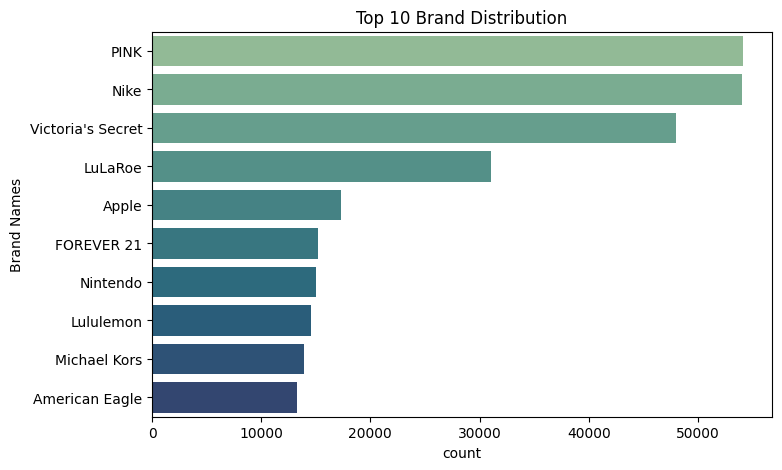

In [23]:
top_10_brands = train['brand_name'].value_counts()[:10].reset_index()
top_10_brands.columns = ['brand_name', 'count']

plt.figure(figsize=(8, 5))
ax = sns.barplot(x="count", y="brand_name", data=top_10_brands, palette="crest")
ax.set_title('Top 10 Brand Distribution', fontsize=12)
plt.ylabel('Brand Names', fontsize=10)
plt.show()

#### Chart - 3 : Distribution of Top 10 Expensive Brands

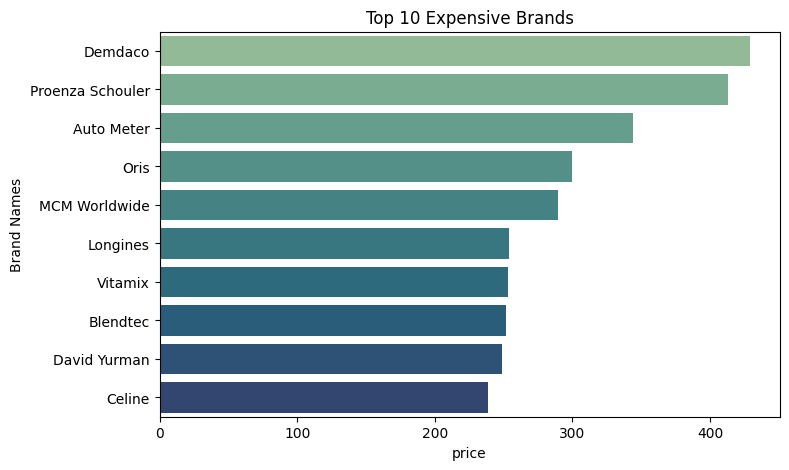

In [24]:

top10_brand = train.groupby('brand_name').mean(numeric_only=True)
df_expPrice = pd.DataFrame(top10_brand['price'].nlargest(10).reset_index())


plt.figure(figsize=(8, 5))


ax = sns.barplot(x="price", y="brand_name", data=df_expPrice, palette="crest")


ax.set_title('Top 10 Expensive Brands', fontsize=12)
plt.ylabel('Brand Names', fontsize=10)


plt.show()

#### Chart - 4 : Distribution of Top 10 Main Categories

In [25]:

def transform_category_name(category_name):
    try:
        main, sub1, sub2 = category_name.split('/')
        return main, sub1, sub2
    except:
        return np.nan, np.nan, np.nan

train['category_main'], train['category_sub1'], train['category_sub2'] = zip(*train['category_name'].apply(transform_category_name))

cat_train = train[['category_main', 'category_sub1', 'category_sub2', 'price']]

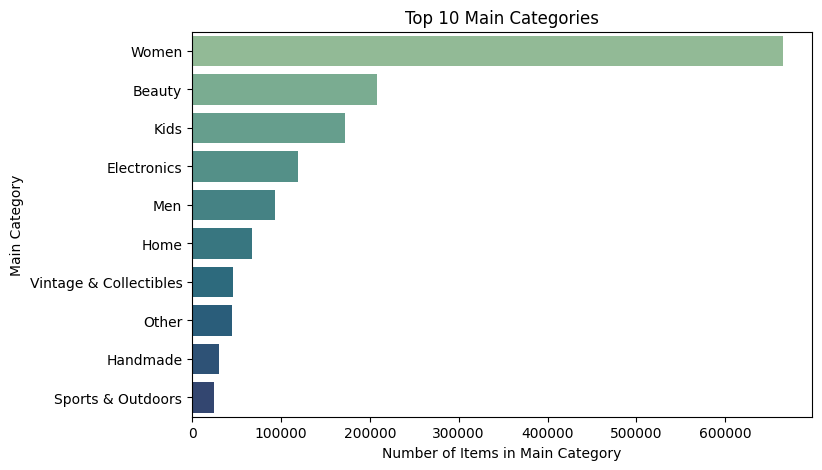

In [26]:

plt.figure(figsize=(8, 5))


sns.countplot(y=train['category_main'], order=train['category_main'].value_counts().index, orient='v', palette="crest")


plt.title('Top 10 Main Categories', fontsize=12)


plt.ylabel('Main Category', fontsize=10)
plt.xlabel('Number of Items in Main Category', fontsize=10)

plt.show()

#### Chart - 5 : Category Distribution With/Without Brand

In [27]:

train['no_brand'] = train['brand_name'].isnull()

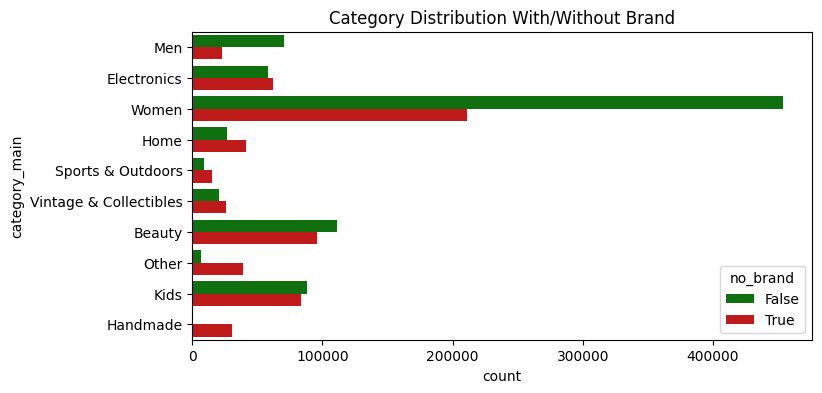

In [28]:

f, ax = plt.subplots(figsize=(8, 4))
sns.countplot(y='category_main', hue='no_brand', data=train, palette=['green', '#db0000'])
ax.set_title('Category Distribution With/Without Brand', fontsize=12)
plt.show()

#### Chart - 6 : Distribution of Top 10 2nd Categories

In [29]:

df = cat_train.groupby(['category_sub2'])['price'].agg(['mean']).reset_index()
df = df.rename(columns={'category_sub2': 'Sub Category 2', 'mean': 'Mean Price'})
df = df.sort_values('Mean Price', ascending=False).head(10)

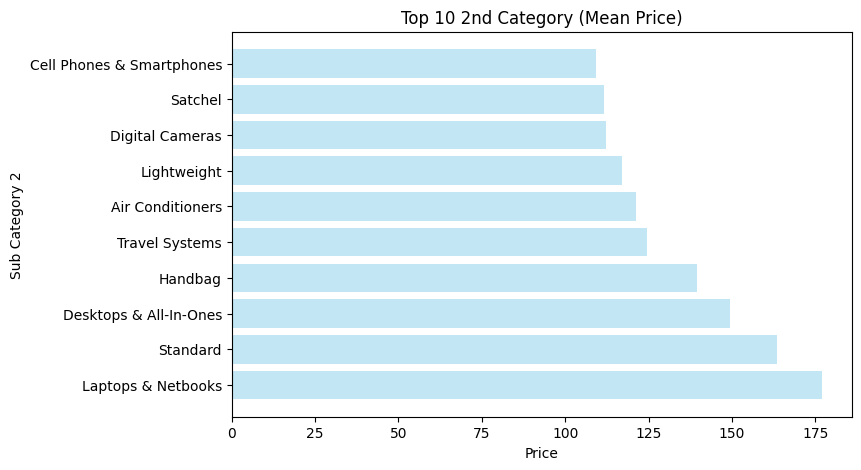

In [30]:

plt.figure(figsize=(8, 5))

plt.barh(range(0, len(df)), df['Mean Price'], align='center', alpha=0.5, color='skyblue')

plt.yticks(range(0, len(df)), df['Sub Category 2'], fontsize=10)

plt.xlabel('Price', fontsize=10)
plt.ylabel('Sub Category 2', fontsize=10)
plt.title('Top 10 2nd Category (Mean Price)', fontsize=12)

plt.show()

#### Chart - 7 : Distribution of Top 10 1st Categories

In [31]:

df = cat_train.groupby(['category_sub1'])['price'].agg(['mean']).reset_index().rename(columns={'index': 'main', 'category_main':'count'})

df = df.sort_values('mean', ascending=False).head(10)

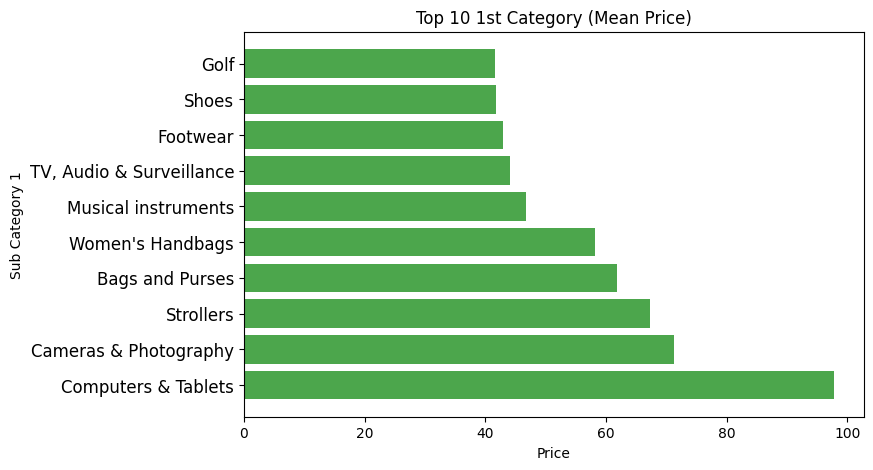

In [32]:

plt.figure(figsize=(8, 5))
plt.barh(range(0, len(df)), df['mean'], align='center', alpha=0.7, color='green')
plt.yticks(range(0, len(df)), df['category_sub1'], fontsize=12)
plt.xlabel('Price', fontsize=10)
plt.ylabel('Sub Category 1', fontsize=10)
plt.title('Top 10 1st Category (Mean Price)', fontsize=12)
plt.show()

#### Chart - 8 : Correlation Heatmap

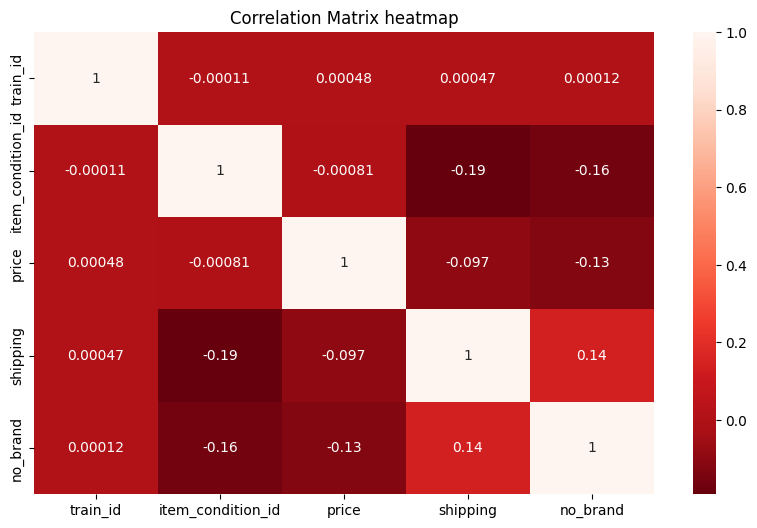

In [33]:

corr_matrix = train.corr(numeric_only=True)


plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Reds_r')

plt.title('Correlation Matrix heatmap')


plt.show()

## ***5. Feature Engineering & Data Pre-processing***

### 1. Textual Data Preprocessing


#### 1. Lower Casing

In [34]:

def to_lower(x):
  return x.lower()

combined['name'] = combined['name'].apply(to_lower)
combined['item_description'] = combined['item_description'].apply(to_lower)

combined_ML['name'] = combined_ML['name'].apply(to_lower)
combined_ML['item_description'] = combined_ML['item_description'].apply(to_lower)

#### 2. Removing Punctuations

In [35]:

def remove_punctuation(text):
    '''a function for removing punctuation'''

    translator = str.maketrans('', '', string.punctuation)
    text_without_punct = text.translate(translator)
    return text_without_punct

combined['name'] = combined['name'].apply(remove_punctuation)
combined['item_description'] = combined['item_description'].apply(remove_punctuation)

combined_ML['name'] = combined_ML['name'].apply(remove_punctuation)
combined_ML['item_description'] = combined_ML['item_description'].apply(remove_punctuation)

#### 3. Removing URLs & Removing words and digits contain digits.

In [36]:

def remove_digits(x):
    x = ''.join([i for i in x if not i.isdigit()])
    return x


combined['name'] = combined['name'].apply(remove_digits)
combined['item_description'] = combined['item_description'].apply(remove_digits)

combined_ML['name'] = combined_ML['name'].apply(remove_digits)
combined_ML['item_description'] = combined_ML['item_description'].apply(remove_digits)

#### 4. Removing Stopwords

In [37]:

stop_words = nltk.corpus.stopwords.words('english')

def remove_stop_words(x):
  ''' function to remove stop words'''
  x = x.split()
  res = ''
  for word in x:
    if word not in stop_words:
      res = res + ' ' + word
  return res

combined['name'] = combined['name'].apply(remove_stop_words)
combined['item_description'] = combined['item_description'].apply(remove_stop_words)

combined_ML['name'] = combined_ML['name'].apply(remove_stop_words)
combined_ML['item_description'] = combined_ML['item_description'].apply(remove_stop_words)

#### 5. Text Vectorization

In [38]:

cv_name = CountVectorizer(min_df=10)
X_name = cv_name.fit_transform(combined['name'])

In [39]:
X_name


<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 8148734 stored elements and shape (2175894, 20470)>

In [40]:
cv_category = CountVectorizer()
X_category = cv_category.fit_transform(combined['category_name'])

In [41]:
X_category

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 8711929 stored elements and shape (2175894, 1022)>

In [42]:

tv_description = TfidfVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english')

X_description = tv_description.fit_transform(combined['item_description'])

In [43]:

lb_brand = LabelBinarizer(sparse_output=True)

X_brand = lb_brand.fit_transform(combined['brand_name'])

### 2. CSR_Matrix & Sparse Matrices

In [44]:

from sklearn.preprocessing import OneHotEncoder
ohe_condition = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_dummies = ohe_condition.fit_transform(combined[['item_condition_id', 'shipping']])

sparse_merge = hstack((X_dummies, X_description, X_brand, X_category, X_name)).tocsr()

### 3. Data Splitting

In [45]:

X_train_sparse = sparse_merge[:train_size]

X_test = sparse_merge[train_size:]

### Cross Validation

In [46]:

eval_size = 0.10


kf = KFold(n_splits=round(1. / eval_size))

train_indices, valid_indices = None, None

for train_index, valid_index in kf.split(X_train_sparse):
    train_indices, valid_indices = train_index, valid_index
    break 
X_train, y_train = X_train_sparse[train_indices], y[train_indices]
X_valid, y_valid = X_train_sparse[valid_indices], y[valid_indices]

## ***6. ML Model Implementation***

In [47]:
def rmsle(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y0), 2)))

### ML Model - 1 : Linear Regression

In [48]:

start_time = time.time()

model = LinearRegression()

model.fit(X_train, y_train)

preds_valid = model.predict(X_valid)

training_time = time.time() - start_time


rmsle_score = rmsle(np.expm1(y_valid), np.expm1(preds_valid))
print('[{}] Linear Regression completed.'.format(training_time))
print("Linear Regression RMSLE: " + str(rmsle_score))


[808.4516460895538] Linear Regression completed.
Linear Regression RMSLE: 0.47482462167113254


In [49]:
np.expm1(preds_valid)

array([  9.4478263 , 105.32914509,   9.44877896, ...,  29.33193461,
         8.72060428,  11.84107342], shape=(148254,))

### ML Model - 2 : Random Forest

In [50]:

model2 = RandomForestRegressor(
    n_estimators=100,       
    max_depth=10,            
    min_samples_split=5,     
    max_features='sqrt',     
    n_jobs=-1                
)

start_time = time.time()

model2.fit(X_train, y_train)

rf_pred = model2.predict(X_valid)

training_time = time.time() - start_time

rmsle_score = rmsle(np.expm1(y_valid), np.expm1(rf_pred))
print('[{}] Random Forest completed.'.format(training_time))
print("Random Forest RMSLE: " + str(rmsle_score))

[69.08200907707214] Random Forest completed.
Random Forest RMSLE: 0.7186009349969588


In [51]:
np.expm1(rf_pred)

array([17.97314571, 19.91986312, 17.78045561, ..., 17.87174666,
       17.63884411, 18.00688711], shape=(148254,))

### ML Model - 3 : Ridge Regression

In [52]:

model3 = Ridge(max_iter=100)

model3.fit(X_train, y_train)
ridge_pred = model3.predict(X_valid)

training_time = time.time() - start_time

rmsle_score = rmsle(np.expm1(y_valid), np.expm1(ridge_pred))
print('[{}] Ridge Regression completed.'.format(training_time))
print("Ridge Regression RMSLE: " + str(rmsle_score))

[84.64646911621094] Ridge Regression completed.
Ridge Regression RMSLE: 0.47468847954878796


In [53]:
np.expm1(ridge_pred)

array([ 9.5148292 , 87.85209682,  8.59669998, ..., 23.94238973,
        8.4191859 , 11.77656372], shape=(148254,))

## ***7. Price Recommendation System***

In [54]:

preds = model3.predict(X_test)

predicted_prices = np.expm1(preds)

submission["price"] = predicted_prices

submission.to_csv("submission_ridge.csv", index=False)

In [55]:
submission

,test_id,price
0,0,10.511475
1,1,12.582151
2,2,49.960371
3,3,16.053734
4,4,7.401700
...,...,...
693354,693354,23.565297
693355,693355,28.140026
693356,693356,6.654496
693357,693357,16.845821


In [56]:

import joblib
import os

print("Pickling components...")

# Save Transformers
joblib.dump(cv_name, 'cv_name.joblib')
joblib.dump(cv_category, 'cv_category.joblib')
joblib.dump(tv_description, 'tv_description.joblib')
joblib.dump(lb_brand, 'lb_brand.joblib')
joblib.dump(ohe_condition, 'ohe_condition.joblib')

# Save Models
if 'model' in locals(): joblib.dump(model, 'linear_regression.joblib')
if 'model2' in locals(): joblib.dump(model2, 'random_forest.joblib')
if 'model3' in locals(): joblib.dump(model3, 'ridge_model.joblib')

print("All components pickled successfully.")


Pickling components...
All components pickled successfully.
